In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras.utils import image_dataset_from_directory
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
df = pd.read_csv("../dataset/breast-cancer-images.csv")
df.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [50]:
df.info()  # Check the data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39545 entries, 0 to 39544
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fold      39545 non-null  int64 
 1   mag       39545 non-null  int64 
 2   grp       39545 non-null  object
 3   filename  39545 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [51]:
df["grp"].value_counts()  # Check the distribution of dataset types


grp
train    25880
test     13665
Name: count, dtype: int64

In [53]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = image_dataset_from_directory(
    "../dataset/train",
    label_mode = "binary",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

validation_ds = image_dataset_from_directory(
    "../dataset/train",
    label_mode = "binary",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 7909 files belonging to 2 classes.
Using 6328 files for training.
Found 7909 files belonging to 2 classes.
Using 1581 files for validation.


In [54]:
class_names = train_ds.class_names
class_names

['benign', 'malignant']

In [58]:
# Step 1: Extract labels from train_ds
all_labels = []
for images, labels in train_ds.unbatch():
    all_labels.append(labels.numpy().item())

# Step 2: Count labels
label_counts = Counter(all_labels)
print("Class distribution:", label_counts)

Class distribution: Counter({1.0: 4352, 0.0: 1976})


In [77]:

classes = np.unique(all_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)

# Convert to dict format
class_weight_dict = {
    int(k): float(v) for k, v in zip(classes, class_weights)
}
print("Class weights:", class_weight_dict)

Class weights: {0: 1.6012145748987854, 1: 0.7270220588235294}


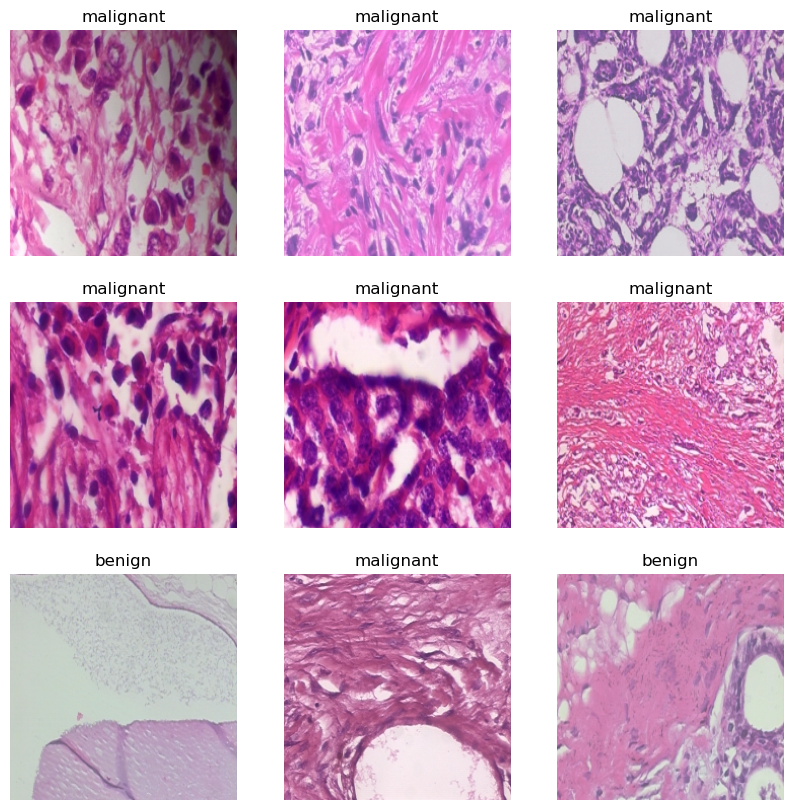

In [66]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[int(labels[i].numpy().item())])
        plt.axis("off")

In [67]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 1)


In [68]:
AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [78]:
num_classes = len(class_names)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model = keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.2),
    keras.layers.Rescaling(1./255),
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('../models/best_cnn_model.keras', save_best_only=True, monitor='val_loss', mode='min')

model.summary()

epochs = 10
cancer_cnn_model = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_7 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_7 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_7               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,921 (12.63 MB)

 Trainable params: 3,309,441 (12.62 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/10
 37/198 ━━━━━━━━━━━━━━━━━━━━ 3:06 1s/step - accuracy: 0.7144 - loss: 5.7474

KeyboardInterrupt: 

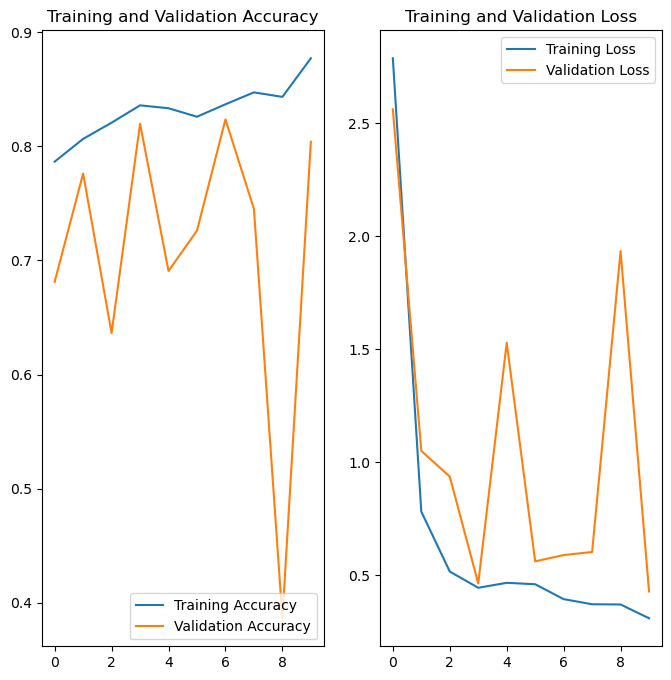

In [44]:
acc = cancer_cnn_model.history['accuracy']
val_acc = cancer_cnn_model.history['val_accuracy']

loss = cancer_cnn_model.history['loss']
val_loss = cancer_cnn_model.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
test_ds = image_dataset_from_directory(
    "../dataset/test",
    label_mode="binary",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Found 6814 files belonging to 2 classes.
213/213 ━━━━━━━━━━━━━━━━━━━━ 58s 274ms/step - accuracy: 0.8034 - loss: 0.4129
Test Accuracy: 80.41%
Test Loss: 0.4105


In [46]:
# Get predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)


213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step


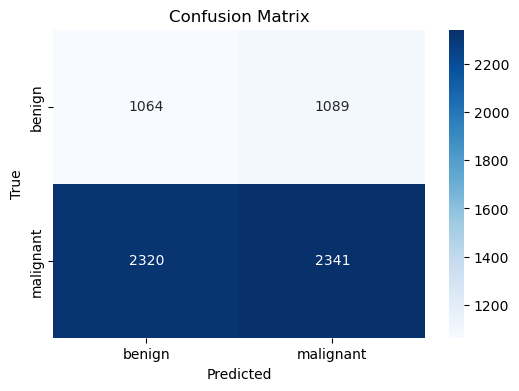

              precision    recall  f1-score   support

      benign       0.31      0.49      0.38      2153
   malignant       0.68      0.50      0.58      4661

    accuracy                           0.50      6814
   macro avg       0.50      0.50      0.48      6814
weighted avg       0.57      0.50      0.52      6814



In [47]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))